# Solution from Johannes Rieke and Alex Moore

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 1

#### 1. Color channels

In [214]:
img = plt.imread('salience/salience_01.png')
img.shape

(99, 150, 3)

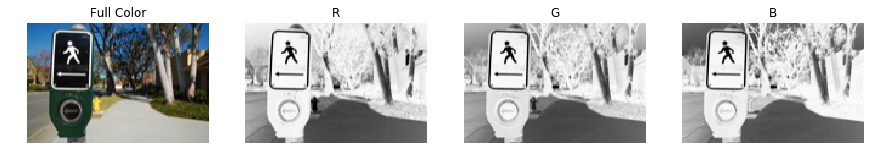

In [215]:
plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(img, interpolation='none')
plt.axis('off')
plt.title('Full Color')

for i in range(3):
    plt.subplot(1, 4, 2+i)
    plt.imshow(img[..., i], interpolation='none', cmap='Greys', vmin=0, vmax=1)
    plt.title('RGB'[i])
    plt.axis('off')

In [216]:
np.corrcoef(np.vstack([img[..., i].flatten() for i in range(3)]))

array([[ 1.        ,  0.94512747,  0.76406375],
       [ 0.94512747,  1.        ,  0.91688974],
       [ 0.76406375,  0.91688974,  1.        ]])

The three color channels are highly correlated with each other. This makes a lot of sense - e.g. very light areas like the walkway in the image above contain high values for all color channels.

The first and third channel (red and blue) seem to be slightly less correlated than the other channels. This could be because they don't appear together very often in natural scenes (e.g. the blue sky in the image above does not contain any red tones). 

#### 2. HSV

In [217]:
from matplotlib.colors import rgb_to_hsv

In [218]:
img_hsv = rgb_to_hsv(img)

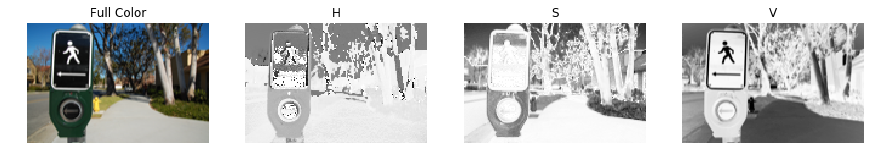

In [219]:
plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(img, interpolation='none')
plt.axis('off')
plt.title('Full Color')

for i in range(3):
    plt.subplot(1, 4, 2+i)
    plt.imshow(img_hsv[..., i], interpolation='none', cmap='Greys', vmin=0, vmax=1)
    plt.title('HSV'[i])
    plt.axis('off')

In [220]:
np.corrcoef(np.vstack([img_hsv[..., i].flatten() for i in range(3)]))

array([[ 1.        ,  0.32958264, -0.08134197],
       [ 0.32958264,  1.        , -0.16244643],
       [-0.08134197, -0.16244643,  1.        ]])

The correlation between the channels is way smaller. This is because the channels in the HSV space are mostly independent - an area with high saturation does not have to have a certain hue (i.e. color).

#### 3. Saliency maps

In [221]:
channels = [img_hsv[..., i] for i in range(3)]
len(channels), channels[0].shape

(3, (99, 150))

In [222]:
from scipy.stats import circstd

In [223]:
saliency_maps = [np.zeros_like(channel) for channel in channels]

for i, (channel, saliency_map) in enumerate(zip(channels, saliency_maps)):
    for x in range(7, channel.shape[0] - 7):
        for y in range(7, channel.shape[1] - 7):
            if i == 0:  # H channel is circular, use circular std
                saliency_map[x, y] = circstd(channel[x-7:x+7, y-7:y+7], high=1)
            else:
                saliency_map[x, y] = np.std(channel[x-7:x+7, y-7:y+7])

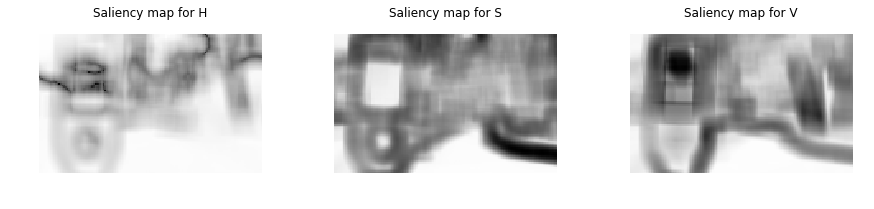

In [224]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, 1+i)
    plt.imshow(saliency_maps[i], interpolation='none', cmap='Greys')
    plt.title('Saliency map for ' + 'HSV'[i])
    plt.axis('off')

The saliency maps show the standard deviation in a small neighborhood of a pixel. Therefore, they represent "changes" of the pixel values in a single channel - e.g. the border between walkway and lawn in the bottom right of the image. 

Each saliency map shows distinct visual features of the original image: The saliency map for V has a dark spot at the figure on the street sign because of the strong black-white contrast. The most pronounced feature in the saliency map for S is the border of the walkway. The saliency map for H puts a highlight on some of the color changes related to the horizon.

#### 5. Joint saliency map

In [225]:
joint_saliency_map = saliency_maps[0] + saliency_maps[1] + saliency_maps[2]

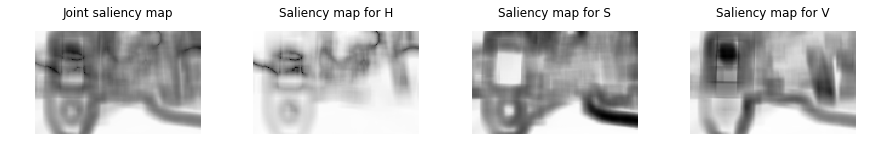

In [226]:
plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(joint_saliency_map, interpolation='none', cmap='Greys')
plt.axis('off')
plt.title('Joint saliency map')

for i in range(3):
    plt.subplot(1, 4, 2+i)
    plt.imshow(saliency_maps[i], interpolation='none', cmap='Greys')
    plt.title('Saliency map for ' + 'HSV'[i])
    plt.axis('off')

#### 6. Smoothing

In [227]:
from scipy.ndimage.filters import gaussian_filter

(-0.5, 149.5, 98.5, -0.5)

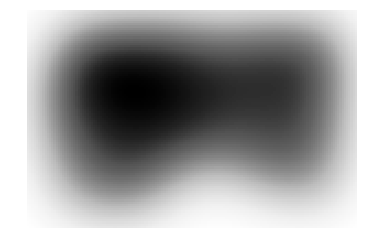

In [228]:
smoothed_joint_saliency_map = gaussian_filter(joint_saliency_map, sigma=15, mode='nearest')
w
plt.imshow(smoothed_joint_saliency_map, interpolation='none', cmap='Greys')
plt.axis('off')

#### 7. & 8. Overlay saliency map

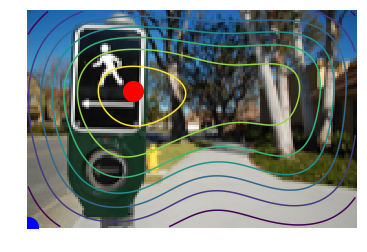

In [229]:
plt.imshow(img, interpolation='none')
plt.axis('off')

plt.contour(smoothed_joint_saliency_map)

most_likely_position = np.unravel_index(np.argmax(smoothed_joint_saliency_map), smoothed_joint_saliency_map.shape)
least_likely_position = np.unravel_index(np.argmin(smoothed_joint_saliency_map), smoothed_joint_saliency_map.shape)
plt.plot(most_likely_position[1], most_likely_position[0], 'ro', markersize=20)
plt.plot(least_likely_position[1], least_likely_position[0], 'bo', markersize=20)

In [230]:
least = np.argmin(smoothed_joint_saliency_map)
least

14700

In [231]:
np.unravel_index(least, smoothed_joint_saliency_map.shape)

(98, 0)

In [186]:
img.shape, smoothed_joint_saliency_map.shape

((99, 150, 3), (99, 150))

The final saliency map makes a lot of sense: A human being would probably attend to the street sign, because it is the most distinct object in the image and very rich in contrast. At the least likely position (blue dot), the image contains only a flat surface (the walkway), which is not very interesting and salient to the eye.

#### 9. More images

In [211]:
def compute_saliency_map(img):
    """Compute a smoothed, joint saliency map from an RGB image and return it."""
    img_hsv = rgb_to_hsv(img)
    channels = [img_hsv[..., i] for i in range(3)]

    saliency_maps = [np.zeros_like(channel) for channel in channels]

    for i, (channel, saliency_map) in enumerate(zip(channels, saliency_maps)):
        for x in range(7, channel.shape[0] - 7):
            for y in range(7, channel.shape[1] - 7):
                if i == 0:  # H channel is circular, use circular std
                    saliency_map[x, y] = circstd(channel[x-7:x+7, y-7:y+7], high=1)
                else:
                    saliency_map[x, y] = np.std(channel[x-7:x+7, y-7:y+7])

    joint_saliency_map = saliency_maps[0] + saliency_maps[1] + saliency_maps[2]

    smoothed_joint_saliency_map = gaussian_filter(joint_saliency_map, sigma=15, mode='nearest')
    return smoothed_joint_saliency_map

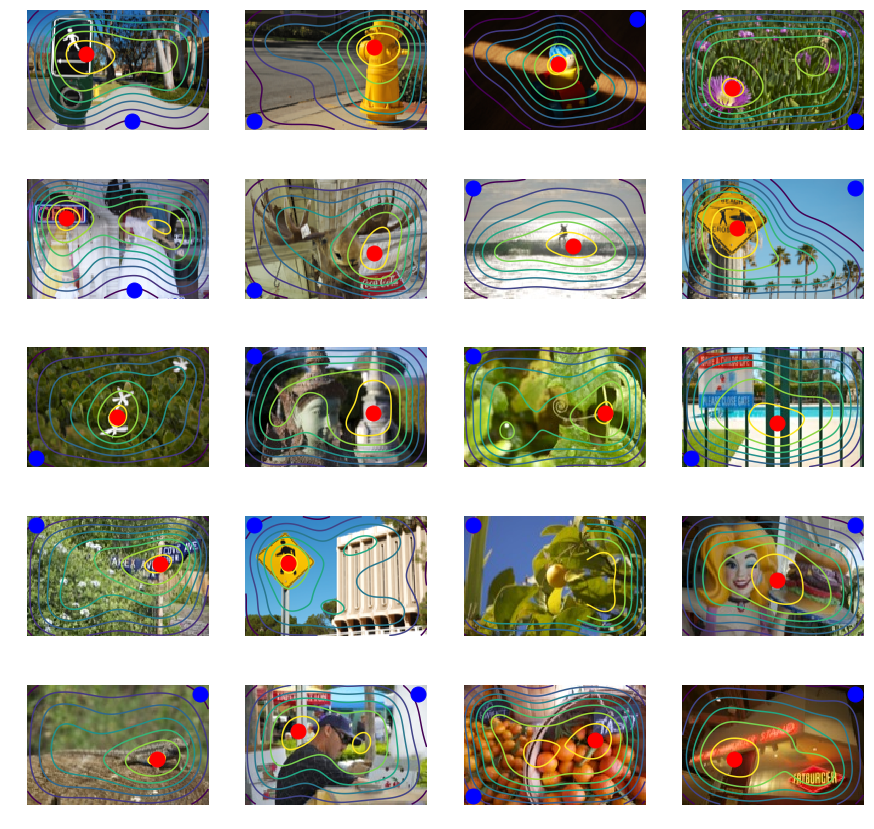

In [238]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15))

import os
for ax, img_filename in zip(axes.flatten(), os.listdir('salience')):
    img = plt.imread(os.path.join('salience', img_filename))

    plt.sca(ax)
    plt.imshow(img, interpolation='none')
    plt.axis('off')
    
    smoothed_joint_saliency_map = compute_saliency_map(img)
    plt.contour(smoothed_joint_saliency_map)
    
    # Compute most and least likely in a crop in the center of the image, otherwise the least likely position always at the outer border.
    offset = 7
    crop = smoothed_joint_saliency_map[offset:-offset, offset:-offset]
    most_likely_position = np.unravel_index(np.argmax(crop), crop.shape)
    least_likely_position = np.unravel_index(np.argmin(crop), crop.shape)
    plt.plot(most_likely_position[1]+offset, most_likely_position[0]+offset, 'ro', markersize=15)
    plt.plot(least_likely_position[1]+offset, least_likely_position[0]+offset, 'bo', markersize=15)

1) The algorithm fails to recognize faces, which are usually very salient for humans. One example is the second image from the left in the bottom row: Even though the person and his face are clearly the most salient features, the face and the shirt have very little variation in terms of the image channels. Therefore, the very diverse area behind the person is the most salient area in this algorithm.

2) Another feature is text. Take the rightmost image in the bottom row: The salient feature for a human is clearly the text. However, the algorithm picks the light bulb, because it has a very high contrast to the surrounding dark area.

#### 10. Center of an image

One could simply add a centered, 2-dimensional Gaussian function to the saliency map.